In [1]:
# default_exp data.core_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# hide
from nbdev.showdoc import *

# Data Core

> Using the fastai2 `Datasets` to make an time series dataset.

For now all is univerable but in the future I would also like to add multiplevariable. 


In [4]:
# export
from fastseq.data.load import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastseq.data.load_pd import *

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

In [146]:
# export
def _zeros_2_ones(o, eps=1e-8):
    nan_mask = o!=o
    o[o < eps ] = 1    
    o[nan_mask ] = 1    
    return o
    

In [154]:
o = np.arange(0,1,.1)
test_close(list(_zeros_2_ones(o,.5)),[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9])

o = np.arange(0,1,.1)[None,:]
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]])

o = torch.arange(0,1,.1)[None,:]
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]]))

o = torch.arange(0,1,.1)[None,:]
o[:,-1]= torch.tensor(float('nan'))
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]]))

o = np.arange(0,1,.1)[None,:]
o[:,-1]= np.nan
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]])

/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [175]:
# export

class NormalizeTSMulti(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`.
        This is for blok seqences to not magnify the `y` part of the data.

        `mean` will set a mean instead of the mean of the x value.
        (
            TensorSeqs(x, label=[self.y_name + '_x'], m=['g']),
            TensorSeqs(tsx,label=self.ts_names),
            TensorCon(cat,label=self.cat_names).long(),
            TensorCon(con,label=self.con_names),
            TensorSeqs(y, label=[self.y_name+ '_y'], m=['r'])
        )
        """
        store_attr(self,'verbose, make_ones, eps, mean')
        self.m, self.s = {}, {}

    def encodes(self, o):
        for i in range(len(o)-1):
            if type(o[i]) == TensorCon and o[i].shape[-1]>0:
                self.m[i] = torch.mean(o[i])
                self.s[i] = torch.std(o[i]) +self.eps
            elif type(o[i]) == TensorSeqs :
                self.m[i] = torch.mean(o[i], -1, keepdim=True)
                self.s[i] = torch.std(o[i],  -1, keepdim=True) +self.eps
                self.s[i] = _zeros_2_ones(self.s[i], self.eps*10)
            else:
                print(f'NormalizeTSMulti:type {type(o[i])} on location:{i}/{len(o)} of tuple not found')
                self.m[i], self.s[i] = 0, 1
                
        # y must be scaled with m
        self.m[len(o)-1], self.s[len(o)-1] = self.m[0],self.s[0]         
            
        # TODO make y its own type
        if self.verbose:
            print('encodes',[a.shape for a in o],'m shape', {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
            
        return MetaTuple([(o[i]-self.m[i]) / self.s[i] for i in range(len(o))])              

    def decodes(self, o):
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',[a.shape for a in o],  {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        return MetaTuple([(o[i]*self.s[i])+self.m[i] for i in range(len(o))])

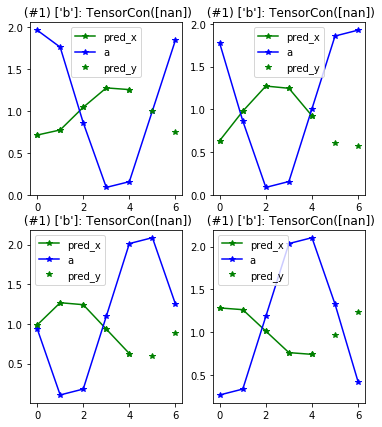

In [176]:
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)],'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)]})
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeTSMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        test_close(a.mean(),0)
        test_close(a.std(),1,.1)
    test_eq(dl.after_batch[0].s[0], dl.after_batch[0].s[len(o)-1])
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),MetaTuple)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()),MetaTuple)

dl.show_batch(max_n = 4)

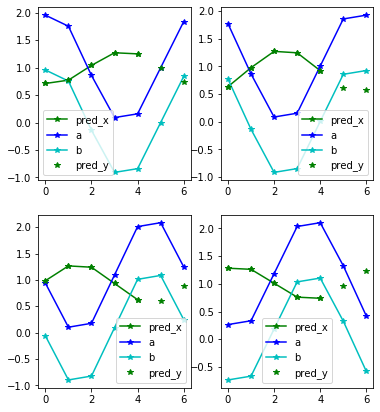

In [178]:
# hide
# basic
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)],'b':[a for _ in range(1,5)]})
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeTSMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        for i in range(a.shape[0]):
            test_close(a[i].mean(),0)
            test_close(a[i].std(),1,.1)
    test_eq(dl.after_batch[0].s[0], dl.after_batch[0].s[len(o)-1])
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),MetaTuple)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()),MetaTuple)

dl.show_batch(max_n = 4)

# TSDataLoaders

## Utils

In [29]:
def concat_ts_list(train, val):
    items=L()
    assert len(train) == len(val)
    for t, v in zip(train, val):
        items.append(np.concatenate([t,v],1))
    return items

In [30]:
a = [np.random.randn(3,10)]*50
b = [np.random.randn(3,5)]*50
r = concat_ts_list(a,b)
test_eq(r[0].shape,(3,15))
test_eq(r[0], np.concatenate([a[0],b[0]],1))

In [31]:
# export
def make_test_df(df:L(), horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the series in `df` based on `horizon + lookback`*, where the last part will go into `val` and the first in `train`.

    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise also lookback.
    """
    train, val = {}, {}  
    for col in df:
        train[col], val[col] = [], []        
        if type(df.loc[0, col])==pd.Series or type(df.loc[0, col]) == np.ndarray:
            for row in df[col]:
                val[col].append(row.flatten()[-(horizon+lookback):])
                if keep_lookback:
                    train[col].append(row.flatten()[:-(horizon)])
                else:
                    train[col].append(row.flatten()[:-(horizon+lookback)])
        else:
            val[col]   = df[col]
            train[col] = df[col]

    return pd.DataFrame(train), pd.DataFrame(val)


In [32]:
# hide
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
train, val = make_test_df(df, 5, 2)
test_eq(train.loc[0,'x'].shape, (63,))
train.head()

,x,weather,city,cont
0,"[-0.5323201964932366, -0.8643264232079727, -0.9767094944848692, -0.99666330575521, -1.1923191191962694, -1.2569083094156162, -0.9792511180692766, -1.1119074531359185, -1.1762552326589704, -1.2033220037194816, -1.1785212582746027, -1.1062950167097998, -1.2064255135295623, -1.1796538351297952, -1.257634450838032, -1.1220190093735773, -1.0278046354628159, -0.762242848587759, -0.7950913711055058, -0.5899270090742839, -0.764610612098377, -0.7048648612942393, -0.4648206554871565, -0.725409498330111, -0.6646783580157667, -0.5125207923552549, -0.5863965740028768, -0.6669483693807607, -0.6849797882...","[8.061938009422116, 7.621398646956028, 7.300004337638707, 7.208538129234326, 7.381168038602092, 7.765326033889195, 8.238069312677972, 8.643811701727625, 8.841894733586058, 8.749538120093813, 8.367142331804198, 7.778274960438814, 7.124341328788765, 6.561608583948613, 6.2136114309558215, 6.133400576515679, 6.287165013940764, 6.564340883405125, 6.811336951266795, 6.878857121260502, 6.668635399404665, 6.165478340033957, 5.444823442625067, 4.653289225322551, 3.9677462885969463, 3.5448716587940616, 3.476034919490765, 3.760835600133748, 4.307116813584089, 4.9574546781568385, 5.53429761952777, 5.8...",0,0.722414
1,"[-2.194457093276084, -2.100194321742739, -1.9099582934385904, -1.8251172594054772, -1.7045399865829818, -1.5636190687241471, -1.4089788101033374, -1.3511050564615281, -1.2293700743120195, -1.1496047542104688, -1.1081067635822277, -1.0228461870092045, -0.9419286109125118, -0.9094345726169449, -0.8070716866024862, -0.7293039276682475, -0.6972806483771667, -0.5615512084980525, -0.429310019667185, -0.3911766345355326, -0.3095449277538347, -0.28601250920715754, -0.24337430697055792, -0.23457327008918025, -0.15276111244261603, -0.07582414464164744, -0.09861479230019268, 0.011576939135725203, 0.0...","[1.3739175670525807, 1.0769661160956407, 0.9591285283806101, 1.110287132357311, 1.5356635002792536, 2.152832313231743, 2.815178548900719, 3.354813065802885, 3.6321247783622352, 3.5771505456779638, 3.2103851929403517, 2.6368027545470687, 2.014874494059034, 1.50984901755792, 1.2452645259118609, 1.2671839063880626, 1.5318242788873153, 1.9202381180519486, 2.275594686756203, 2.4518373922185894, 2.359083905989263, 1.9921126558146915, 1.4333489606095977, 0.8294078426879135, 0.3481784435330755, 0.12927184872105402, 0.24265119915262767, 0.6678216696375552, 1.299809225778238, 1.9801426040136394, 2.5...",0,0.384862
2,"[-2.437874256277358, -2.2251483682169, -2.0794433552695626, -1.9001355632625643, -1.4261580299912342, -1.2587985636350207, -1.2378882304016878, -0.6938221452269655, -0.37842263152408734, -0.1391479945689459, 0.2574238602920847, 0.6210977594866168, 0.8070082492552089, 0.9597949350838085, 1.1905229041946215, 1.1503008101740073, 1.345248558862694, 1.1402049659636946, 1.1062515849962409, 0.9781362544024734, 0.6918872594371483, 0.6351591375113738, 0.3865089834797128, 0.22762672726002212, 0.08121507343581677, 0.040513395188484035, 0.012524793096137467, -0.06762764374312277, -0.06135840083904745,...","[2.9574554324069218, 2.870627572399454, 2.9721894832215945, 3.2441341062930467, 3.6365170545480523, 4.082907955026751, 4.5176535046557476, 4.890002503887093, 5.171496496478884, 5.355378462434942, 5.44936705345951, 5.465179251311099, 5.409042843285956, 5.276879115168107, 5.056058379686001, 4.733219083490342, 4.305376648244697, 3.79016897399407, 3.2310572975656457, 2.6946704984797685, 2.2598565232063996, 2.0006715445986116, 1.967672189021887, 2.1727963180109375, 2.582492562658008, 3.121715212839043, 3.6884943354776354, 4.1758457165802625, 4.495654567118589, 4.598480994752841, 4.4842133451143...",0,0.365854
3,"[1.6046560421626646, 1.4877029987152037, 1.4114375829536134, 1.0405163992063329, 1.1363146594601994, 0.9547895843226185, 0.7620396664250483, 0.9215395812111956, 1.0215978693477332, 1.1038691482906873, 1.3896956743424902, 1.4198690953698412, 1.804546747957264, 1.716422128554127, 1.9279718308520477, 1.8569494268979856, 1.8097

In [33]:
a = pd.DataFrame({'a':[np.arange(0,15)]*50,'b':[np.arange(0,15)]*50, 'c':[3]*50})
train, val = make_test_df(a,5,2)
test_eq(train['a'][0].max(),7)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                          a                         b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

In [34]:
# hide
train, val = make_test_df(a,5,2,True)
test_eq(train['a'][0].max(),9)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                                a                               b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

## Dataloaders

In [35]:
#export
class DfDataLoaders(DataLoaders):
    @classmethod
    @delegates(DfDataLoader.__init__)
    def from_df(cls, dataset:pd.DataFrame, y_name:str, horizon:int, valid_pct=1.5, seed=None, lookback=None, step=1,
                   incl_test = True, path:Path='.', device=None, norm=True, **kwargs):
        """Create an list of time series.
        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        lookback = ifnone(lookback, horizon * 4)
        device = ifnone(device, default_device())
        if incl_test:
            dataset, test = make_test_df(dataset, horizon, lookback, keep_lookback = True)
        train, valid = make_test_df(dataset, horizon + int(valid_pct*horizon), lookback , keep_lookback = True)
        if norm and 'after_batch' not in kwargs:
            make_ones = kwargs.pop('make_ones', True)
            kwargs.update({'after_batch':L(NormalizeTSMulti(make_ones=make_ones))})
        db = DataLoaders(*[DfDataLoader(ds, y_name, horizon=horizon, lookback=lookback, step=step, device=device, norm = False, **kwargs)
                           for ds in [train,valid]], path=path, device=device)
        if incl_test:
            db.test = DfDataLoader(test, y_name, horizon=horizon, lookback=lookback, step=step, name='test', device=device, **kwargs)

            print(f"Train:{db.train.n}; Valid: {db.valid.n}; Test {db.test.n}")
        else:
            print(f"Train:{db.train.n}; Valid: {db.valid.n}")

        return db

In [36]:
# hide
# device `cpu`
horizon,lookback = 2,5
t = np.arange(-5,25)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,100)],'a':[i+a for i in range(1,100)]})


In [37]:
# hide
data = DfDataLoaders.from_df(df, 'pred', horizon = horizon, lookback=lookback, step=5, device = torch.device('cpu'))
test_eq(data.valid.dataset.iloc[0,0].shape[-1],data.valid.dataset.iloc[0,1].shape[-1])
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], torch.device('cpu'))
test_eq([o[0].device for o in data.test][0], torch.device('cpu'))

Train:396; Valid: 99; Test 99


In [38]:
# hide
# default device

data = DfDataLoaders.from_df(df,'pred', horizon = horizon, lookback=lookback, step=5)
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], default_device())
test_eq([o[0].device for o in data.test][0], default_device())

Train:396; Valid: 99; Test 99


In [39]:
# hide
dbunch = DfDataLoaders.from_df(df,'pred',horizon=horizon, lookback = lookback, incl_test=False)
test_eq(hasattr(dbunch,'test'),False)

Train:1881; Valid: 396


In [40]:
show_doc(DfDataLoaders.from_df, name='DfDataLoaders.from_df')

<h4 id="DfDataLoaders.from_df" class="doc_header"><code>DfDataLoaders.from_df</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>DfDataLoaders.from_df</code>(**`dataset`**:`DataFrame`, **`y_name`**:`str`, **`horizon`**:`int`, **`valid_pct`**=*`1.5`*, **`seed`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`incl_test`**=*`True`*, **`path`**:`Path`=*`'.'`*, **`device`**=*`None`*, **`norm`**=*`True`*, **`min_seq_len`**=*`None`*, **`max_std`**=*`None`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create an list of time series.
The `DataLoader` for the test set will be save as an attribute under `test`

In [41]:
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
df['city'] = df['city'].astype(float)
df.head(3)

,x,weather,city,cont
0,"[[-1.1225401490583198, -0.9487845015092735, -1.2454426483431476, -1.0860764105204466, -1.0773317085586924, -0.9485867017686594, -0.9032806789325545, -0.6359915462151895, -0.425334584732365, -0.19645540253247867, -0.2723225429211374, 0.2793510040946203, 0.4121038816373146, 0.6095292660460946, 0.5432415660989776, 0.3398289576645315, 0.7245377191772827, 0.4321128410822884, 0.467728756536086, 0.35332873005476795, 0.5544223840558199, 0.12071965263435695, -0.07412683858510774, 0.02221081039257443, -0.5366764119508192, 0.03813956399091084, 0.3601148358475471, 0.20918032163425002, 0.55056149482309...","[[2.2212185755022222, 2.184790736385729, 2.0427763932506138, 1.8170819516124936, 1.5409152779771298, 1.254300793457912, 0.9986739539213806, 0.8112851620707207, 0.7201688941489763, 0.7403574885782214, 0.8718509453584561, 1.0996169260676067, 1.3956209544626301, 1.7226126278403884, 2.0391564903341988, 2.30522812083083, 2.487619652824433, 2.5644246807994144, 2.527996841682934, 2.385982498547863, 2.1602880569096974, 1.8841213832743349, 1.5975068987551395, 1.3418800592186209, 1.1544912673679195, 1.0633749994461685, 1.0835635938754087, 1.2150570506556224, 1.442823031364798, 1.7388270597598323, 2....",0.0,-1.623600
1,"[[2.2140144844592706, 2.047842683152121, 1.8498644043518384, 1.6574758344236713, 1.546501262300731, 1.3871589655570702, 1.326488607241701, 1.2385340355069365, 1.1717529983201451, 1.1269073211706975, 1.081346736150163, 1.0550602107698472, 1.0077979099806154, 0.9451304067589806, 0.8802256030925136, 0.8840755366997718, 0.7283016427695493, 0.6926855290882679, 0.5786457163462568, 0.5656026365154498, 0.44502218278228695, 0.35121789821008803, 0.275493873747363, 0.1883775063582886, 0.16044585624187718, 0.10310539434437586, -0.0011626578003935488, 0.037155926125411506, 0.060830520480033505, 0.00219...","[[0.48757681819691034, 0.49479350408866374, 0.49821877927606717, 0.4958192624307905, 0.4846173306847314, 0.4612459510333498, 0.42260984829673476, 0.36655668546460884, 0.2924589892075047, 0.20161831044446915, 0.09742615848628003, -0.014751492746438277, -0.12796219342814322, -0.23428656788452532, -0.32561662968861943, -0.3944976638753753, -0.4349285960091155, -0.44301978360381067, -0.41742459109015084, -0.35948965403745586, -0.27310461493172483, -0.16427054820864836, -0.040442168833326075, 0.09027253676733599, 0.21995419291904034, 0.34165034979620135, 0.4499950334781972, 0.5415967346542645, ...",0.0,-0.353101
2,"[[2.332638553266076, 2.102890201834593, 1.8647018780368119, 1.714657037626228, 1.5240901369041497, 1.5533889256102937, 1.4688207527132793, 1.2559468459112535, 1.231710777280685, 1.1593121343975645, 0.9144395645133245, 0.6253511016088523, 0.4823331236461817, 0.3862906784693669, 0.339335632903975, 0.20320582028262996, 0.22556613832245515, 0.20120765638696023, 0.27092974735290487, 0.28849820700543044, 0.3314129833299113, 0.25706043044059235, 0.3865784411390732, -0.010340774750452041, -0.06044891476996682, -0.24179721983970837, -0.2420580404809869, -0.3633199285448924, -0.3787619774246319, -0....","[[10.40741989440929, 10.1226300355716, 10.026046743537899, 10.17211054006254, 10.539991047899914, 11.031301488645477, 11.492937561897003, 11.759043836024743, 11.699999746669267, 11.263772876385852, 10.49683155984031, 9.537549463120108, 8.583003769363048, 7.83791544547635, 7.459870754113803, 7.5162771529861665, 7.965323122962879, 8.666438876472698, 9.417365284741205, 10.007384030288012, 10.271749200361954, 10.132196267224195, 9.612610906329587, 8.826251903943396, 7.939166123847239, 7.121176654867956, 6.499099957534404, 6.125733259470162, 5.973043611845955, 5.950467578465931, 5.9415856973114...",0.0,0.399558


Train:120; Valid: 110; Test 10


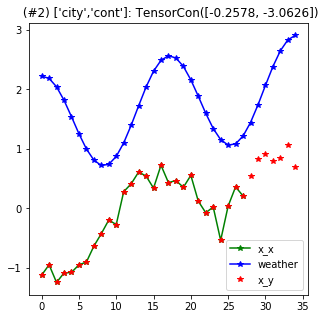

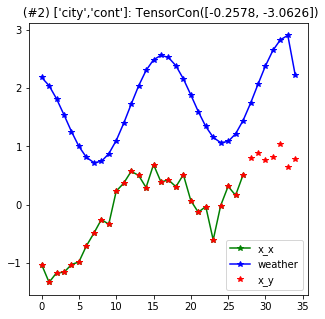

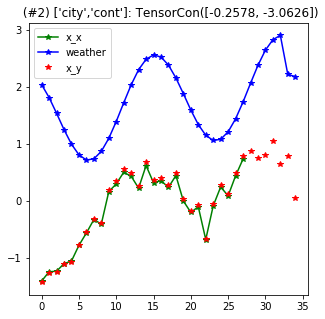

In [42]:
dbunch =  DfDataLoaders.from_df(df, 'x', horizon = 7, lookback=28, step=1, bs=32)
dbunch.train.show_batch(max_n=3)

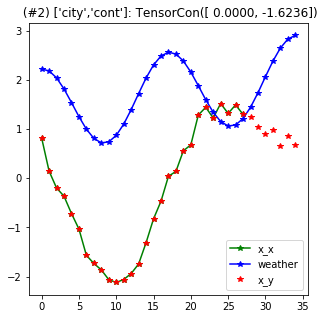

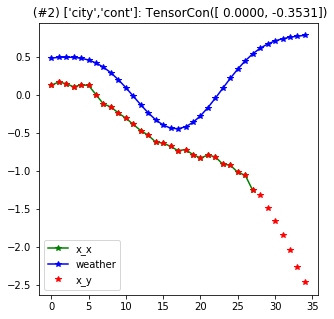

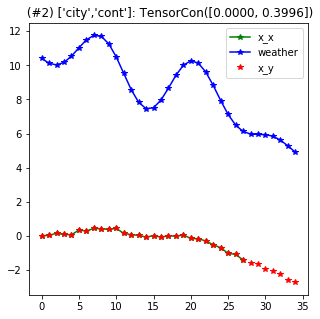

In [44]:
dbunch.test.show_batch(max_n=3)

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 03_data.core_pd.ipynb.
Converted 050_nbeats.models_multi.ipynb.
